# Case Plotting Example

Here, we show how the Covid-19 Datalake can be queried, and metrics evaluated to produce case plots over time of the Covid-19 pandemic.

In [2]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import dateutil
import numpy as np
import json
import os

## Define global information needed to query the public API

All Public API requests need to come with a set of headers, and all stem from a base URL. These are defined here for future convenience.

In [3]:
# Necessary headers for all requests
headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json'
}

base_url = 'https://api.c3.ai/covid/api/1'

## Dataset Exploration - Locations

We're interested in plotting cases over time for various locations. Before we do this, we need to know the id for the various locations we're interested in. For this test, we're interested in a couple counties in the state of Illinois. First, we fetch outbreakLocations whose id contains the substring 'Illinois' and include some additional information so we can check the data.

In [4]:
# List outbreaklocations
data = json.dumps({
    'spec': {
        'filter': 'contains(id, "Illinois")',
        'include': 'id, name, fips, lineList',
        'limit': -1,
        'offset': 0,
    }
})

r = requests.post(os.path.join(base_url, 'outbreaklocation', 'fetch'),
                  headers=headers,
                  data=data)

outbreak_location_fetch_df = pd.DataFrame(json.loads(r.text)['objs'])

In [5]:
# Show all 'Illinois' outbreak locations
outbreak_location_fetch_df[outbreak_location_fetch_df.lineList.notna()]

,fips,id,name,meta,version,typeIdent,lineList
9,{'id': '17019'},Champaign_Illinois_UnitedStates,"Champaign County, Illinois, United States","{'fetchInclude': '[id,name,fips,{lineList:[id]...",9568281,EP_LOC,[{'location': {'id': 'Champaign_Illinois_Unite...
10,NaN,Chicago_Illinois_UnitedStates,Chicago,"{'fetchInclude': '[id,name,fips,{lineList:[id]...",2359297,EP_LOC,[{'location': {'id': 'Chicago_Illinois_UnitedS...
14,{'id': '17027'},Clinton_Illinois_UnitedStates,"Clinton County, Illinois, United States","{'fetchInclude': '[id,name,fips,{lineList:[id]...",9699353,EP_LOC,[{'location': {'id': 'Clinton_Illinois_UnitedS...
16,{'id': '17031'},Cook_Illinois_UnitedStates,"Cook County, Illinois, United States","{'fetchInclude': '[id,name,fips,{lineList:[id]...",10092569,EP_LOC,[{'location': {'id': 'Cook_Illinois_UnitedStat...
18,{'id': '17035'},Cumberland_Illinois_UnitedStates,"Cumberland County, Illinois, United States","{'fetchInclude': '[id,name,fips,{lineList:[id]...",9175065,EP_LOC,[{'location': {'id': 'Cumberland_Illinois_Unit...
19,{'id': '17037'},DeKalb_Illinois_UnitedStates,"DeKalb County, Illinois, United States","{'fetchInclude': '[id,name,fips,{lineList:[id]...",9895961,EP_LOC,[{'location': {'id': 'DeKalb_Illinois_UnitedSt...
21,{'id': '17041'},Douglas_Illinois_UnitedStates,"Douglas County, Illinois, United States","{'fetchInclude': '[id,name,fips,{lineList:[id]...",8978457,EP_LOC,[{'location': {'id': 'Douglas_Illinois_UnitedS...
22,{'id': '17043'},DuPage_Illinois_UnitedStates,"DuPage County, Illinois, United States","{'fetchInclude': '[id,name,fips,{lineList:[id]...",10092569,EP_LOC,[{'location': {'id': 'DuPage_Illinois_UnitedSt...
28,{'id': '17055'},Franklin_Illinois_UnitedStates,"Franklin County, Illinois, United States","{'fetchInclude': '[id,name,fips,{lineList:[id]...",9830425,EP_LOC,[{'location': {'id': 'Franklin_Illinois_United...
32,{'id': '17063'},Grundy_Illinois_UnitedStates,"Grundy County, Illinois, United States","{'fetchInclude': '[id,name,fips,{lineList:[id]...",9961497,EP_LOC,[{'location': {'id': 'Grundy_Illinois_UnitedSt...


With all Illinois outbreak locations displayed, we pick a couple of Illinois counties to inspect further. For the future, we pick Champaign county, DuPage county, and Cook county.

## Build helper to reduce evalmetrics result into usable form

By itself, the result of the evalmetrics query is not exactly usable. We define here, a helper function to transform this result into a usable pandas dataframe, which we can then manipulate and plot.

In [6]:
# Ingest metrics
def ingest_evalmetrics(json_result):
    results = []
    for ID in json_result['result']:
        for expression in json_result['result'][ID]:
            if json_result['result'][ID][expression]['type'] == 'MaterializedTimeseriesDouble':
                count = json_result['result'][ID][expression]['count']
                dates = pd.Series(json_result['result'][ID][expression]['dates'])
                dates = dates.apply(lambda d: dateutil.parser.isoparse(d))
                data = pd.Series(json_result['result'][ID][expression]['data']).astype(np.int)
                missing = pd.Series(json_result['result'][ID][expression]['missing']).astype(np.int)
                
                results.append(pd.DataFrame({'date': dates,
                                             'data': data,
                                             'id': [ID]*count,
                                             'expression': [expression]*count,
                                             'missing': missing}))
    return pd.concat(results)

## Fetch Case data from evalmetrics API

Armed with the ids of the counties we want to extract data from, we can evaluate the metrics `JHU_ConfirmedCasese`, `JHU_ConfirmedDeaths`, and `JHU_ConfirmedRecoveries` to extract the cases, deaths, and recoveries as measured and published by Johns Hopkins University.

In the spec sent to the evalmetrics API, we send the outbreakLocation ids in the `ids` field, and the metrics we want to evaluate in the `expressions` field. Finally, we specify we want the data split up per-day and we specify a start and end date.

The helper function we defined earlier helps turn the result into a useful pandas dataframe.

In [7]:
data = json.dumps({
  "spec": {
    "ids": [
      "Champaign_Illinois_UnitedStates",
      "DuPage_Illinois_UnitedStates",
      "Cook_Illinois_UnitedStates"
    ],
    "expressions": [
      "JHU_ConfirmedCases",
      "JHU_ConfirmedDeaths",
      "JHU_ConfirmedRecoveries",
    ],
    "interval": "DAY",
    "start": "2020-01-01",
    "end": "2020-06-11"
  }
})

r = requests.post(os.path.join(base_url, 'outbreaklocation', 'evalmetrics'),
                  headers=headers,
                  data=data)
cases_df = ingest_evalmetrics(json.loads(r.text))

## Plot Case and Death values

Now with a dataframe containing all rows of data we requested, we can plot this data over time. First however, we need to properly group the data by expression and id since the data from all expressions and locations exist together in the same DataFrame. We first, group by `expression`, then fetch the appropriate expression whether that's `JHU_ConfirmedCases` or `JHU_ConfirmedDeaths`. Then we set the `id` and `date` as a multi-level index, and use `.loc` to select the location we want by id. This leaves a DataFrame whose index is the date the data was taken. We can then call the `.plot` function of the DataFrame with the `data` column to produce the plots below.

Text(0.5, 0, 'Date')

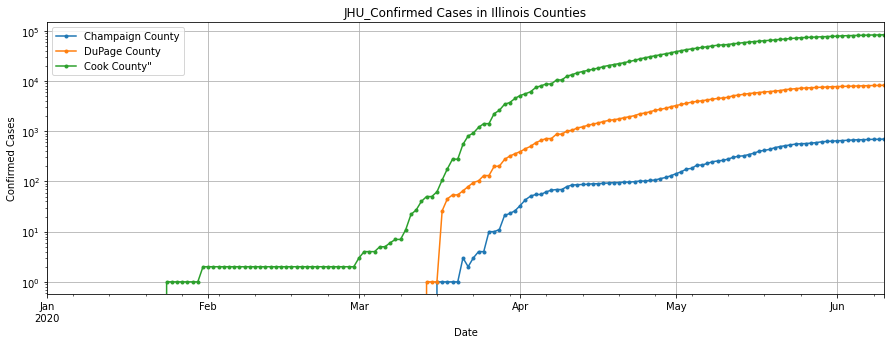

In [8]:
_, ax = plt.subplots(1, figsize=(15,5))

cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Champaign County')
cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='DuPage County')
cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Cook County"')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Cases in Illinois Counties")
ax.set_ylabel("Confirmed Cases")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

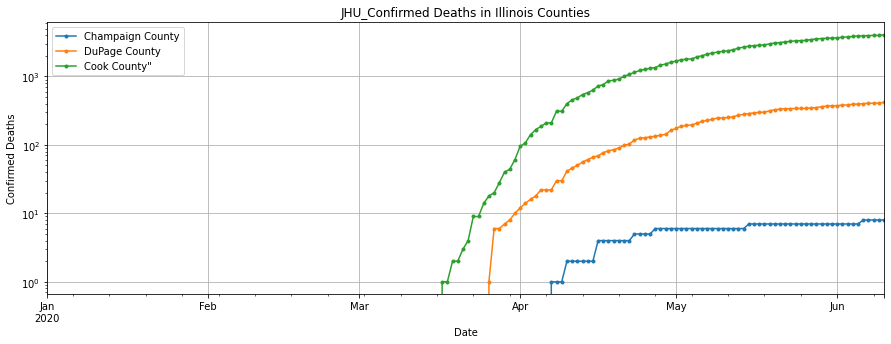

In [9]:
_, ax = plt.subplots(1, figsize=(15,5))

cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Champaign County')
cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='DuPage County')
cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Cook County"')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Deaths in Illinois Counties")
ax.set_ylabel("Confirmed Deaths")
ax.set_xlabel('Date')

## Get location information about Illinois Counties

Now, we'd like to augment these plots by plotting per-capita cases and deaths instead. First, we need to get each counties population. Here we fetch outbreakLocation data this time getting all properties. Finally, we set the location id as the index of the dataset to facilitate its usage later.

In [10]:
# Get populations
data = json.dumps({
    'spec': {
        'filter': 'contains(id, "_Illinois_")',
    }
})

r = requests.post(os.path.join(base_url, 'outbreaklocation', 'fetch'),
                  headers=headers,
                  data=data)
illinois_location_df = pd.DataFrame(json.loads(r.text)['objs']).set_index('id')

In [11]:
illinois_location_df

,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,populationOfAllChildren,locationType,populationCDS,location,fips,name,meta,version,typeIdent
id,,,,,,,,,,,,,
Adams_Illinois_UnitedStates,25.0,248.0,307.0,65435.0,65435.0,county,65435.0,{'value': {'id': 'Adams_Illinois_UnitedStates'...,{'id': '17001'},"Adams County, Illinois, United States","{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",10092571,EP_LOC
Alexander_Illinois_UnitedStates,NaN,NaN,NaN,5761.0,5761.0,county,5761.0,{'value': {'id': 'Alexander_Illinois_UnitedSta...,{'id': '17003'},Alexander,"{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",8585238,EP_LOC
Bond_Illinois_UnitedStates,6.0,32.0,42.0,16426.0,16426.0,county,16426.0,{'value': {'id': 'Bond_Illinois_UnitedStates'}...,{'id': '17005'},"Bond County, Illinois, United States","{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",9895963,EP_LOC
Boone_Illinois_UnitedStates,NaN,NaN,NaN,53544.0,53544.0,county,53544.0,{'value': {'id': 'Boone_Illinois_UnitedStates'...,{'id': '17007'},"Boone County, Illinois, United States","{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",9043995,EP_LOC
Brown_Illinois_UnitedStates,NaN,NaN,NaN,6578.0,6578.0,county,6578.0,{'value': {'id': 'Brown_Illinois_UnitedStates'...,{'id': '17009'},Brown,"{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",7536656,EP_LOC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whiteside_Illinois_UnitedStates,13.0,121.0,123.0,55175.0,55175.0,county,55175.0,{'value': {'id': 'Whiteside_Illinois_UnitedSta...,{'id': '17195'},"Whiteside County, Illinois, United States","{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",10682409,EP_LOC
Will_Illinois_UnitedStates,97.0,850.0,1023.0,690743.0,690743.0,county,690743.0,{'value': {'id': 'Will_Illinois_UnitedStates'}...,{'id': '17197'},"Will County, Illinois, United States","{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",10551336,EP_LOC
Williamson_Illinois_UnitedStates,28.0,294.0,327.0,66597.0,66597.0,county,66597.0,{'value': {'id': 'Williamson_Illinois_UnitedSt...,{'id': '17199'},"Williamson County, Illinois, United States","{'tenantTagId': 4, 'tenant': 'covid', 'tag': '...",10485802,EP_LOC


## Plot per-capita cases and deaths

We can now join the latest population data to the original dataframe by using the 'id' key in the original DataFrame. We can then divide the data by the population column to get the 'per-capita' values.

In [12]:
cases_per_capita_df = cases_df.join(illinois_location_df[['latestTotalPopulation']], on='id')
cases_per_capita_df.data = cases_per_capita_df.data.astype(np.float32)/cases_per_capita_df.latestTotalPopulation

Text(0.5, 0, 'Date')

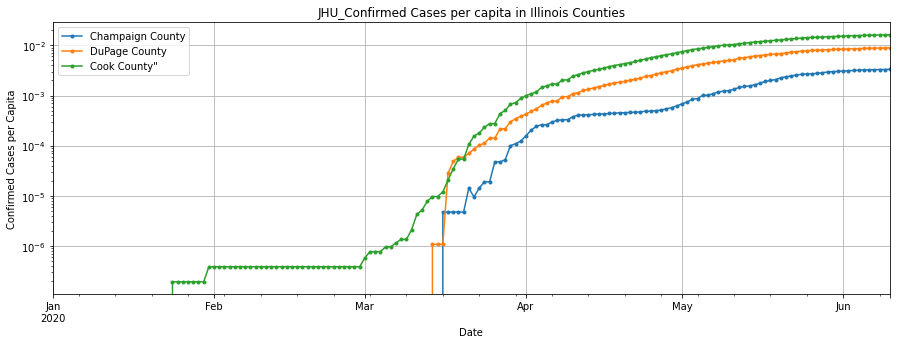

In [14]:
_, ax = plt.subplots(1, figsize=(15,5))

cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Champaign County')
cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='DuPage County')
cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Cook County"')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Cases per capita in Illinois Counties")
ax.set_ylabel("Confirmed Cases per Capita")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

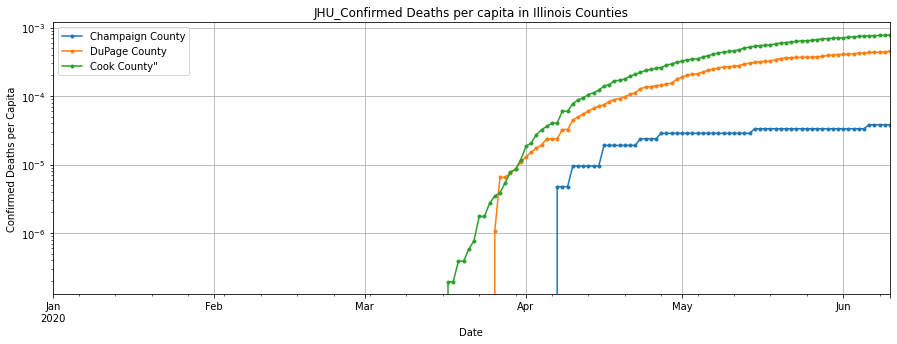

In [15]:
_, ax = plt.subplots(1, figsize=(15,5))

cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Champaign County')
cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='DuPage County')
cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates'].plot(y='data', ax=ax, marker='.', label='Cook County"')
ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed Deaths per capita in Illinois Counties")
ax.set_ylabel("Confirmed Deaths per Capita")
ax.set_xlabel('Date')

## Plot daily new cases and deaths

Another augmentation we can imagine is plotting the new cases and deaths per day. As the dataset only contains the total number of cases and deaths accumulated until that point in time, we will need to do some additional data processing. Thankfully pandas includes the very handy `shift` function which shifts a pandas Series or DataFrame by a specified amount. We can essentially subtract yesterday's values from the current day, then drop the days (first day in this case) whose subtraction is not defined.

Once the difference is defined, we can plot it just like we did before!

In [16]:
def build_case_differences(cases_df):
    data = cases_df['data']
    cases_df['data_diff'] = data-data.shift(1)
    cases_df = cases_df.dropna()
    return cases_df

Text(0.5, 0, 'Date')

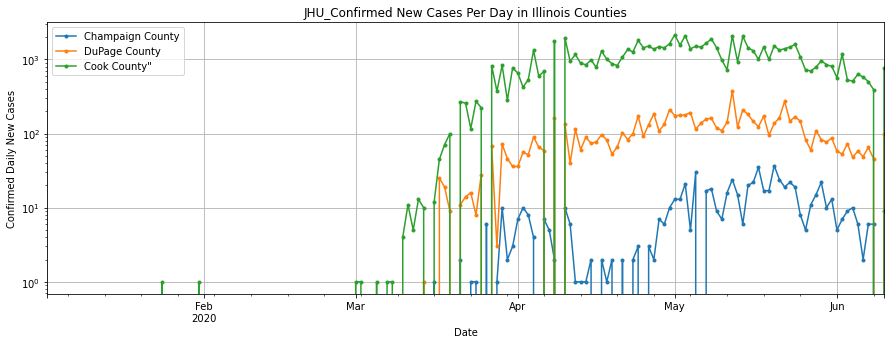

In [17]:
_, ax = plt.subplots(1, figsize=(15,5))

build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='Champaign County')
build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='DuPage County')
build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='Cook County"')

ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed New Cases Per Day in Illinois Counties")
ax.set_ylabel("Confirmed Daily New Cases")
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

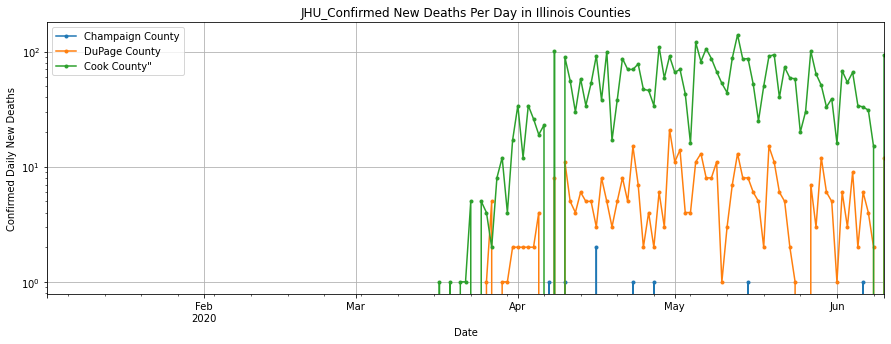

In [18]:
_, ax = plt.subplots(1, figsize=(15,5))

build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='Champaign County')
build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='DuPage County')
build_case_differences(cases_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates']).plot(y='data_diff', ax=ax, marker='.', label='Cook County"')

ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed New Deaths Per Day in Illinois Counties")
ax.set_ylabel("Confirmed Daily New Deaths")
ax.set_xlabel('Date')

## Plot daily new cases and deaths per-capita

Finally, we can divide these new-case and new-deaths per day numbers by the location's population to get the per-capita version of these numbers.

In [19]:
def build_case_differences_per_capita(cases_per_capita_df):
    data = cases_per_capita_df['data']
    cases_per_capita_df['data_diff'] = data-data.shift(1)
    cases_per_capita_df = cases_per_capita_df.dropna()
    cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
    return cases_per_capita_df

<ipython-input-19-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
<ipython-input-19-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
<ipython-input-19-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Text(0.5, 0, 'Date')

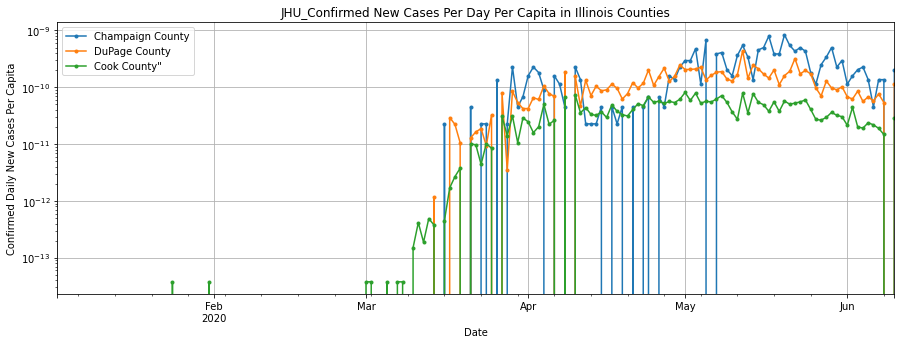

In [20]:
_, ax = plt.subplots(1, figsize=(15,5))

build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='Champaign County')
build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='DuPage County')
build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedCases').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='Cook County"')

ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed New Cases Per Day Per Capita in Illinois Counties")
ax.set_ylabel("Confirmed Daily New Cases Per Capita")
ax.set_xlabel('Date')

<ipython-input-19-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
<ipython-input-19-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_per_capita_df['data_diff_per_capita'] = cases_per_capita_df['data_diff']/cases_per_capita_df['latestTotalPopulation']
<ipython-input-19-e75132945bf5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Text(0.5, 0, 'Date')

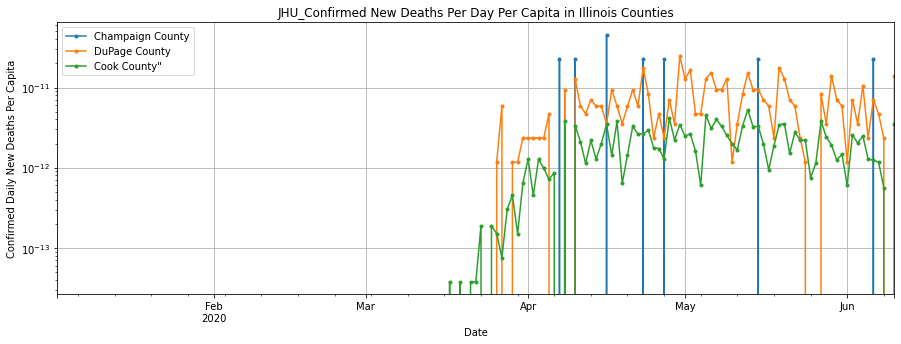

In [21]:
_, ax = plt.subplots(1, figsize=(15,5))

build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Champaign_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='Champaign County')
build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['DuPage_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='DuPage County')
build_case_differences_per_capita(cases_per_capita_df.groupby('expression').get_group('JHU_ConfirmedDeaths').set_index(['id', 'date']).loc['Cook_Illinois_UnitedStates']).plot(y='data_diff_per_capita', ax=ax, marker='.', label='Cook County"')

ax.grid(which='major', axis='both')
ax.set_yscale('log')
ax.set_title("JHU_Confirmed New Deaths Per Day Per Capita in Illinois Counties")
ax.set_ylabel("Confirmed Daily New Deaths Per Capita")
ax.set_xlabel('Date')